## Задача понижения размерности данных

Что такое изображение?

![img](https://mymodernmet.com/wp/wp-content/uploads/2017/08/monovision-awards-bw-series-of-the-year-2017-02.jpg)

Формально, просто набор чисел, например, картинка сверху - это матрица 500х750:

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

url = 'https://mymodernmet.com/wp/wp-content/uploads/2017/08/monovision-awards-bw-series-of-the-year-2017-02.jpg'

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('L')
print(np.array(img).shape)
np.array(img)

(500, 750)


array([[145, 145, 144, ..., 142, 143, 144],
       [146, 146, 146, ..., 141, 143, 144],
       [146, 147, 146, ..., 140, 142, 143],
       ...,
       [114, 111, 120, ...,  78,  69,  56],
       [ 75,  83, 104, ...,  53,  51,  64],
       [ 63,  82, 108, ..., 101,  95,  94]], dtype=uint8)

Что если взять случайную точку в пространстве 500*750? Будет ли это какое-то осмысленное изображение? Проверим

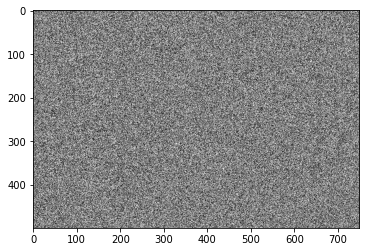

In [2]:
sample_img = np.random.choice(np.arange(256), size=500*750).reshape(500, 750)
plt.imshow(sample_img, cmap='gray')
plt.show()

Вероятно, что осмысленные изображение занимают лишь небольшую долю среди всевозможных числовых матриц? Как описать это подмножество (хотя бы его часть)?

Будем тренироваться строить описание на основе датасете MNIST:

In [3]:
from sklearn.datasets import fetch_openml
digits = fetch_openml('mnist_784')
digits.data.shape

(70000, 784)

In [4]:
images = digits.data.values.reshape(-1, 28, 28)

Пример картинки из датасета:

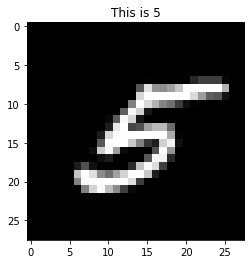

In [5]:
i = 985
plt.imshow(images[i], cmap='gray')
plt.title('This is {}'.format(digits.target[i]))
plt.show()

Воспользуемся моделью PCA:

![img](https://i.stack.imgur.com/G7Gkv.png)

Намопним, PCA ищет подпространство меньшей (но заданной) размерности, проекция на которое максимизирует дисперсию или, что то же самое, минимизирует суммарную ошибку:

![img](http://alexhwilliams.info/itsneuronalblog/img/pca/pca_two_views.png)

Детальное изложение с формулами здесь https://www.csd.uwo.ca/~oveksler/Courses/CS434a_541a/Lecture7.pdf

Пример применение модели PCA (что здесь происходит?):

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)

X_transformed = pca.fit_transform(digits.data.astype(float))
X_transformed.shape

(70000, 50)

Дисперсии вдоль главных компонент:

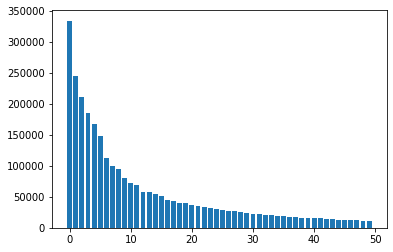

In [7]:
plt.bar(np.arange(50), pca.explained_variance_)
plt.show()

А вот как распределен датасет MNIST в пространстве первых двух главных компонент (разные цвета означают разные цифры на картинках):

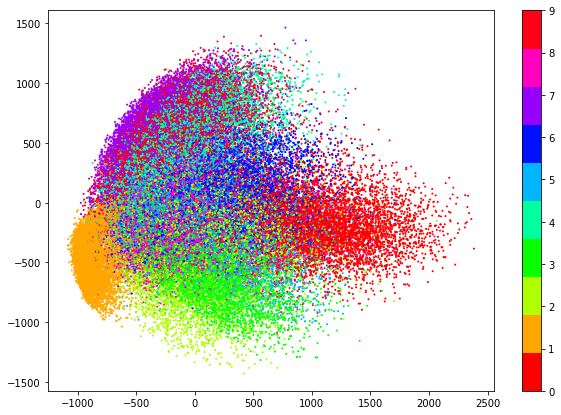

In [8]:
plt.figure(figsize=(10, 7))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=digits.target.astype(int), 
            cmap=plt.cm.get_cmap('hsv', 10), s=1)
plt.colorbar()
plt.show()

Разберем, что стоит за операцией transform. Это всего лишь операция проектирования в новый базис:

In [9]:
proj = np.dot(digits.data.astype(float) - pca.mean_, pca.components_.T)
proj.shape

(70000, 50)

И мы получаем ту же самую картинку:

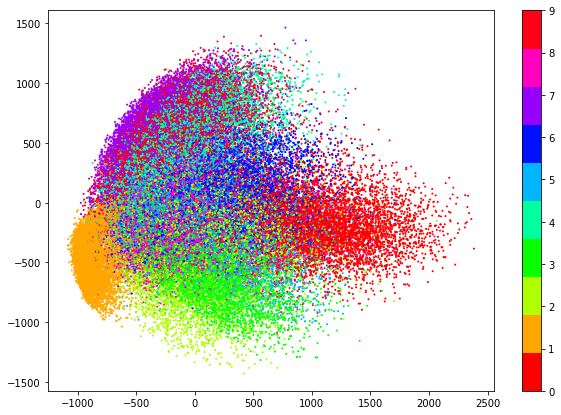

In [10]:
plt.figure(figsize=(10, 7))
plt.scatter(proj[:, 0], proj[:, 1], c=digits.target.astype(int), 
            cmap=plt.cm.get_cmap('hsv', 10), s=1)
plt.colorbar()
plt.show()

Картинка в 3D:

In [11]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X_transformed.T[:3], c=digits.target.astype(int), cmap='hsv')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Теперь выполним обратное преобразование:

In [12]:
X_restored = pca.inverse_transform(X_transformed)
X_restored.shape

(70000, 784)

Слева оригинал, справа - изображение, восстановленное из проекции

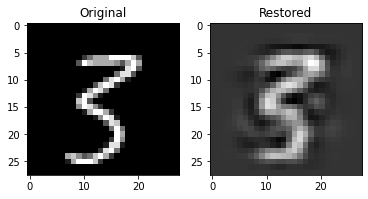

In [13]:
%matplotlib inline
i = 540
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(X_restored[i].reshape(28, 28), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Restored')
plt.show()

### Задача 1
Выпишите явное линейное преобразование, которое отображает точку из подространства главных компонент в исходное пространство (заполните ??? так, чтобы результат совпал с результатом в предыдущей ячейке)

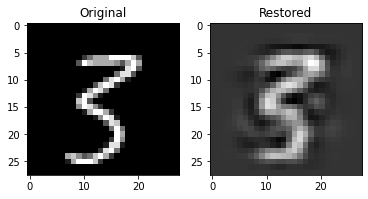

In [14]:
res = np.dot(X_transformed, pca.components_) + pca.mean_

i = 540
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(res[i].reshape(28, 28), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Restored')
plt.show()

### Задача 2

Определите, сколько нужно взять главных компонент, чтобы объяснить  99%, 95%, 90%, и 85% исходной дисперсии.

In [15]:
pca = PCA()
X = pca.fit_transform(digits.data.astype(float))

In [16]:
comp_99 = np.argwhere (np.cumsum(pca.explained_variance_ratio_) >= 0.99)[0][0]
comp_95 = np.argwhere (np.cumsum(pca.explained_variance_ratio_) >= 0.95)[0][0]
comp_90 = np.argwhere (np.cumsum(pca.explained_variance_ratio_) >= 0.90)[0][0]
comp_85 = np.argwhere (np.cumsum(pca.explained_variance_ratio_) >= 0.85)[0][0]
print ("Количество компонент для объяснения:", ";\n99% дисперсии: ", comp_99, ";\n95% дисперсии: ", comp_95, ";\n90% дисперсии: ", comp_90, ";\n85% дисперсии: ", comp_85, ".", sep = "")

Количество компонент для объяснения:;
99% дисперсии: 330;
95% дисперсии: 153;
90% дисперсии: 86;
85% дисперсии: 58.


### Задача 3

Нарисуйте пример исходного изображения и результат восстановления из числа компонент, которое вы нашли в предыдущей задаче.

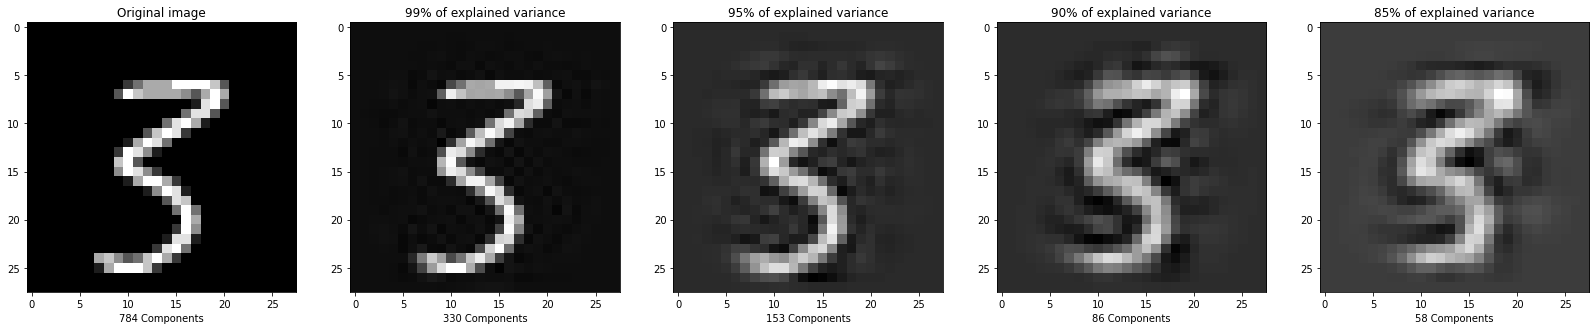

In [17]:
fig, ax = plt.subplots(1, 5, figsize = (28, 28))

ax[0].imshow(images[i], cmap='gray')
ax[0].set_title('Original image')
ax[0].set_xlabel(str(X.shape[1]) + ' Components') 

pca = PCA(n_components=comp_99)
ax[1].imshow(pca.inverse_transform(pca.fit_transform(digits.data.astype(float)))[i].reshape(28, 28), cmap='gray')
ax[1].set_title('99% of explained variance')
ax[1].set_xlabel(str(comp_99) + ' Components') 

pca = PCA(n_components=comp_95)
ax[2].imshow(pca.inverse_transform(pca.fit_transform(digits.data.astype(float)))[i].reshape(28, 28), cmap='gray')
ax[2].set_title('95% of explained variance')
ax[2].set_xlabel(str(comp_95) + ' Components') 

pca = PCA(n_components=comp_90)
ax[3].imshow(pca.inverse_transform(pca.fit_transform(digits.data.astype(float)))[i].reshape(28, 28), cmap='gray')
ax[3].set_title('90% of explained variance')
ax[3].set_xlabel(str(comp_90) + ' Components') 

pca = PCA(n_components=comp_85)
ax[4].imshow(pca.inverse_transform(pca.fit_transform(digits.data.astype(float)))[i].reshape(28, 28), cmap='gray')
ax[4].set_title('85% of explained variance')
ax[4].set_xlabel(str(comp_85) + ' Components') 

plt.show()